# OUTLINE
* Introduce DALBAR study, criticisms
* Methodology for using ETFs instead of MFs.  Reasoning - precise, daily, ascendant
* Choose a basket of ETFs: SPY, sectors, vol & other hot fads, small, trader funds (2x and 3x) etc...
* Pick one major fund in depth, track across time, 
* calculate a composite of many funds, find consistent level.  This is headline takeaway
* try comparing Vanguard to Powershares, etc...  Generalize
* try comparing boring funds to trendy funds. Generalize


   

# Timing of ETF Inflows and Outflows
# Title = Our Own Worst Enemies


## Introduction

I recently heard an investment advisor remark "We don't worry so much about an _investment's_ returns, we are most concerned with the _investor's_ returns."  The advi





In [1]:
from __future__ import print_function
from __future__ import division
from importlib import reload

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import seaborn as sns
import datetime

import os
os.getcwd()

## NOTE: Add paths to dependencies on any machine being used here.  Invalid paths will be silently ignored  
import sys
sys.path.append('/anaconda2/') # either place your config.py in this path, or add another sys.path.append() pointing to your path for config.py
import config ## TODO: place file called config.py in the /anaconda2/ folder

sys.path.append(config.REPO_ROOT+'data/') #Chad: Home
from prices.eod import iqfeed
from prices.eod.read import get_adjustment_factors




In [ ]:
reload(iqfeed)
#symbols = ['IBB','TLT','EEM','XLE','GLD','AGG','QQQ','FXI']
symbols = ['XLK','XLY','XLB','XLE','XLV','XLU','XLI','XLP']

#price = iqfeed.read_etf_daily(symbol)
price = iqfeed.read_etf_daily(symbols)
so = iqfeed.read_etf_so(symbols)
df = price[['close']].join(so)
df = df[df.so>0]

adj_factors = get_adjustment_factors(symbols).stack()
adj_factors.name = 'adj_factors'
#df = df.join(adj_factors)

df['close_adj'] = df.close * adj_factors
df['daily_ret'] = df.close.pct_change()
df['daily_ret_adj'] = df.close_adj.pct_change()

df['flow'] = np.log(df.so).diff()

df['mkt_cap'] = df.so*df.close
df['mkt_cap_adj'] = df.so*df.close_adj

df = df[df.daily_ret.abs()<0.2] # filter likely outliers
df = df[df.flow.abs()<0.50] # catch and exclude any rows with massive (erroneous) flows

df = df.xs(slice('2010-01-01',None),level='date',drop_level=False)
#df.dropna().tail()
#df.groupby(level='date').sum().resample('BM').sum().flow.abs().hist(bins=50)

In [117]:
## fix problem with SO counts
# off by 1000 at some date

In [125]:
df.flow.unstack().resample('BM').sum()['2010':].sum()

symbol
XLB    0.346396
XLE    0.968409
XLI    0.785528
XLK    0.417184
XLP    0.644731
XLU    0.219201
XLV    0.651549
XLY    0.947654
dtype: float64

In [142]:
def calc_twr(df,div_adj=True):
    if div_adj == True:
        cum_ret = (df.daily_ret_adj+1).product() - 1
    else:    
        cum_ret = (df.daily_ret+1).product() - 1
    return cum_ret

def calc_approx_mwr(df,div_adj=True):
    ''' Calculate the return for the full time period normalized for amount of capital deployed.
    '''
    if div_adj == True:
        # First, calculate the invested "basis" in terms of day 0 dollars.      
        adj_flows = df.flow*(df.mkt_cap_adj/df.mkt_cap_adj.iloc[0]) 
        adj_flows.iloc[0] = 1 # initial principal
        basis = (adj_flows).cumsum() #cumulative contributions in beginning of period dollars

        # Next, convert daily returns to log basis and weight by amount of capital deployed
        # to calculate an average compound return rate (log)
        log_rets = np.log(df.daily_ret_adj+1)
        
    else:
        # First, calculate the invested "basis" in terms of day 0 dollars.      
        adj_flows = df.flow*(df.mkt_cap/df.mkt_cap.iloc[0]) 
        adj_flows.iloc[0] = 1 # initial principal
        basis = (adj_flows).cumsum() #cumulative contributions in beginning of period dollars

        # Next, convert daily returns to log basis and weight by amount of capital deployed
        # to calculate an average compound return rate (log)
        log_rets = np.log(df.daily_ret+1)
        
    avg_daily_log_ret = (log_rets*basis / basis.mean()).mean()
    
    # finally, convert into a simple return for the full period
    cum_ret = (avg_daily_log_ret+1)**(len(log_rets))-1
    cr2 = np.exp(avg_daily_log_ret*len(basis))-1
    #print(cr2)
    return cum_ret

df.sort_index(inplace=True)

for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    tmp = df.xs(slice('2009-01-01','2017-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    print("For: {}".format(symbol))
    print("     MWR (adj): {}".format(calc_approx_mwr(tmp,True)))
    print("     TWR (adj): {}".format(calc_twr(tmp,True)))
    #print("     MWR: {}".format(calc_approx_mwr(tmp,False)))
    #print("     TWR: {}".format(calc_twr(tmp,False)))
    print()


For: XLK
     MWR (adj): 2.1002171089670485
     TWR (adj): 2.19294512134664

For: XLY
     MWR (adj): 2.4065680518774677
     TWR (adj): 2.731905027562895

For: XLB
     MWR (adj): 1.3353461744478752
     TWR (adj): 1.1996197751356554

For: XLE
     MWR (adj): 0.3571862762732654
     TWR (adj): 0.5131729855733134

For: XLV
     MWR (adj): 1.897090462560414
     TWR (adj): 2.050439258024531

For: XLU
     MWR (adj): 1.1349095458303085
     TWR (adj): 1.2913229568352098

For: XLI
     MWR (adj): 2.057241737287271
     TWR (adj): 2.2079506860212827

For: XLP
     MWR (adj): 1.501985780748846
     TWR (adj): 1.6630445713264552



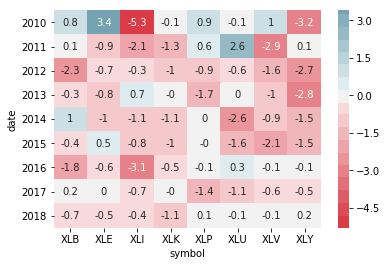

In [140]:
def compare_annual(df):
    symbols = df.index.get_level_values('symbol').unique().tolist()
    
    out = pd.DataFrame()
    for symbol in symbols:
        twr = df.xs(symbol,level='symbol').resample('A').apply(calc_twr,div_adj=True)
        twr.name = 'twr'
        mwr = df.xs(symbol,level='symbol').resample('A').apply(calc_approx_mwr,div_adj=True)
        mwr.name = 'mwr'
        both = pd.concat([twr,mwr],axis=1).reset_index()
        both['symbol'] = symbol
        both.set_index(['date','symbol'],inplace=True)
        both['timing_impact'] = both.mwr - both.twr
        out = pd.concat([out,both],axis=0)
    return out

by_year = compare_annual(df).timing_impact.unstack().round(3)*100
by_year.index = by_year.index.year
title = ''
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=2, n=21),annot=True)
#.xs(slice('2009-01-01','2009-12-31'),level='date',drop_level=False)

In [98]:
df.flow.unstack().resample('A').sum()


symbol,EEM,MUB,SPY,XLE
date,,,,
2009-12-31,0.188744,7.464191,6.584577,6.938737
2010-12-31,0.058007,0.226958,-0.045534,0.240482
2011-12-31,-0.150550,0.172117,0.046260,-0.212504
2012-12-31,0.252886,0.294072,0.136664,-0.041481
2013-12-31,-0.129296,-0.076070,0.085203,-0.050950
2014-12-31,-0.169710,0.253603,0.104939,0.505644
2015-12-31,-0.229752,0.319181,-0.202596,0.160884
2016-12-31,0.126949,0.380611,0.158217,0.279634
2017-12-31,0.124519,0.134855,0.037262,0.067917


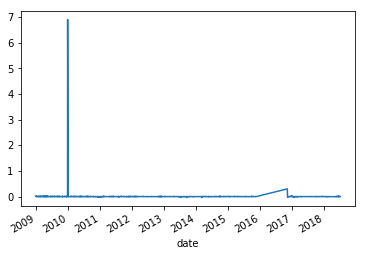

In [102]:
df.xs('MUB',level='symbol').flow.plot()

In [73]:
df.loc['2009'].xs('MUB',level='symbol')['2009-12']

,close,so,close_adj,daily_ret,daily_ret_adj,flow,mkt_cap,mkt_cap_adj
date,,,,,,,,
2009-12-01,102.7300,15200.0,80.898172,-0.002234,0.000692,0.000000,1.561496e+06,1.229652e+06
2009-12-02,102.9200,15200.0,81.047794,0.001850,0.001850,0.000000,1.564384e+06,1.231926e+06
2009-12-03,102.8300,15200.0,80.976921,-0.000874,-0.000874,0.000000,1.563016e+06,1.230849e+06
2009-12-04,103.1300,15200.0,81.213166,0.002917,0.002917,0.000000,1.567576e+06,1.234440e+06
2009-12-07,103.0500,15200.0,81.150167,-0.000776,-0.000776,0.000000,1.566360e+06,1.233483e+06
2009-12-08,103.3399,15200.0,81.378458,0.002813,0.002813,0.000000,1.570766e+06,1.236953e+06
2009-12-09,103.4081,15200.0,81.432165,0.000660,0.000660,0.000000,1.571803e+06,1.237769e+06
2009-12-10,103.1500,15200.0,81.228915,-0.002496,-0.002496,0.000000,1.567880e+06,1.234680e+06
2009-12-11,103.1300,15400.0,81.213166,-0.000194,-0.000194,0.013158,1.588202e+06,1.250683e+06


In [89]:

#cash_flow_series = np.array([begin_val]),net_flows.values,end_val])
#np.irr(cash_flow_series)

In [214]:
df = ibb.xs(slice('2012-01-01',None),level='date',drop_level=False)#ibb.loc[slice('2014-01-04',None)]
adj_flows = df.flow*(df.mkt_cap/df.mkt_cap.iloc[0]) #contributions in beginning of period dollars
adj_flows.iloc[0] = 1 # initial principal
basis = (adj_flows).cumsum() #cumulative contributions in beginning of period dollars
adj_ret = df.daily_ret*basis # daily returns weighted by amount of capital
adj_growth_factor = adj_ret + 1
print("MWR: {}".format(((adj_ret+1).product()-1)/basis.mean()))
print("TWR: {}".format(calc_twr(df)))


MWR: -0.18491837846508344
TWR: 1.7661715380929603


In [11]:
def calc_approx_mwr(df):
    ''' Calculate the return for the full time period normalized for amount of capital deployed.
    '''
    
    # First, calculate the invested "basis" in terms of day 0 dollars.  
    adj_flows = df.flow*(df.mkt_cap/df.mkt_cap.iloc[0]) 
    adj_flows.iloc[0] = 1 # initial principal
    basis = (adj_flows).cumsum() #cumulative contributions in beginning of period dollars
    
    # Next, convert daily returns to log basis and weight by amount of capital deployed
    # to calculate an average compound return rate (log)
    log_rets = np.log(df.daily_ret+1)
    avg_daily_log_ret = (log_rets*basis / basis.mean()).mean()
    
    # finally, convert into a simple return for the full period
    cum_ret = (avg_daily_log_ret+1)**(len(log_rets))-1
    
    return cum_ret

df = spy.loc['2012']
print("MWR: {}".format(calc_approx_mwr(df)))
print("TWR: {}".format(calc_twr(df)))

NameError: name 'spy' is not defined

In [12]:
twr = ibb.xs('IBB',level='symbol').resample('A').apply(calc_twr)
twr.name = 'twr'

mwr = ibb.xs('IBB',level='symbol').resample('A').apply(calc_dollar_wtd_return)
mwr.name = 'mwr'
a = pd.concat([twr,mwr],axis=1)
a

NameError: name 'ibb' is not defined

In [296]:
mwr

date
2001-12-31   -0.150529
2002-12-31   -0.207484
2003-12-31    0.259101
2004-12-31    0.121244
2005-12-31    0.028147
2006-12-31    0.145736
2007-12-31    0.020229
2008-12-31   -0.409775
2009-12-31    0.239060
2010-12-31    0.129616
2011-12-31   -0.007705
2012-12-31    0.122251
2013-12-31    0.287759
2014-12-31    0.098671
2015-12-31    0.017413
2016-12-31    0.064487
2017-12-31    0.084245
Freq: A-DEC, dtype: float64

In [119]:
def OLD_calc_mwr(df):
    ''' irr in period'''
    begin_val = 10000.
    
    end_val = df.mkt_cap[-1]/df.mkt_cap[0]*10000.
    cum_flow = (df.flow+1).cumprod()-1
    
    balance = pd.Series(index=net_flows.index)
    balance.iloc[0] = begin_val #+ net_flows.iloc[0]
    
    
    net_flows.iloc[-1] = end_val + net_flows.iloc[-1]
    irr = np.irr(net_flows)
    print(irr)
    print(net_flows)
    
    cum_ret = (1+irr)**len(net_flows)-1
    
    return cum_ret


,,close,so,daily_ret,flow,mkt_cap
date,symbol,,,,,
2017-06-28,SPY,243.49,982682112.0,0.008950,-0.003549,2.392733e+11
2017-06-29,SPY,241.35,981332096.0,-0.008789,-0.001374,2.368445e+11
2017-06-30,SPY,241.80,978982144.0,0.001865,-0.002395,2.367179e+11
2017-07-03,SPY,242.21,979182144.0,0.001696,0.000204,2.371677e+11
2017-07-05,SPY,242.77,977582144.0,0.002312,-0.001634,2.373276e+11


In [231]:
(np.log((df.daily_ret+1)).mean()+1)**(len(df.daily_ret))-1

1.7646530733454409

In [13]:
df = ibb.loc['2012']#.xs(slice('2012-01-01',None),level='date',drop_level=False)
# TWR (weight all equally)
log_rets = np.log((df.daily_ret+1))
avg_daily_log_ret = log_rets.mean()
compound_growth = (avg_daily_log_ret+1)**(len(df.daily_ret))-1
print("TWR: {}".format(compound_growth))

# MWR (weight by dollar values)
log_rets = np.log(df.daily_ret+1)
avg_daily_log_ret = (log_rets*basis / basis.mean()).mean()
compound_growth = (avg_daily_log_ret+1)**(len(df.daily_ret))-1
print("MWR: {}".format(compound_growth))


NameError: name 'ibb' is not defined

In [277]:
df['log_ret'] = np.log(1+df.daily_ret)
df['adj_flow'] = df.flow*(df.mkt_cap/df.mkt_cap.iloc[0])
df['future_avg_log_ret'] = df.sort_index(ascending=False).log_ret.expanding().mean() 
df.future_avg_log_ret*df.flow


C:\Anaconda2\envs\blog\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda2\envs\blog\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda2\envs\blog\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

date        symbol
2012-01-03  IBB       0.000008
2012-01-04  IBB       0.000008
2012-01-05  IBB       0.000049
2012-01-06  IBB       0.000000
2012-01-09  IBB      -0.000007
2012-01-10  IBB      -0.000007
2012-01-11  IBB       0.000029
2012-01-12  IBB      -0.000051
2012-01-13  IBB      -0.000006
2012-01-17  IBB       0.000000
2012-01-18  IBB      -0.000009
2012-01-19  IBB      -0.000012
2012-01-20  IBB       0.000000
2012-01-23  IBB      -0.000006
2012-01-24  IBB       0.000020
2012-01-25  IBB       0.000038
2012-01-26  IBB       0.000013
2012-01-27  IBB       0.000003
2012-01-30  IBB       0.000010
2012-01-31  IBB       0.000016
2012-02-01  IBB      -0.000005
2012-02-02  IBB      -0.000029
2012-02-03  IBB       0.000009
2012-02-06  IBB       0.000000
2012-02-07  IBB       0.000004
2012-02-08  IBB       0.000000
2012-02-09  IBB       0.000023
2012-02-10  IBB       0.000009
2012-02-13  IBB      -0.000004
2012-02-14  IBB       0.000004
                        ...   
2012-11-16  IBB     

In [261]:
np.e**(log_rets.cumsum())-1


date        symbol
2012-01-03  IBB       0.009296
2012-01-04  IBB       0.004983
2012-01-05  IBB       0.019166
2012-01-06  IBB       0.027408
2012-01-09  IBB       0.041687
2012-01-10  IBB       0.062290
2012-01-11  IBB       0.068807
2012-01-12  IBB       0.076282
2012-01-13  IBB       0.076665
2012-01-17  IBB       0.083373
2012-01-18  IBB       0.095640
2012-01-19  IBB       0.090656
2012-01-20  IBB       0.082894
2012-01-23  IBB       0.076378
2012-01-24  IBB       0.082607
2012-01-25  IBB       0.109056
2012-01-26  IBB       0.099281
2012-01-27  IBB       0.112985
2012-01-30  IBB       0.107810
2012-01-31  IBB       0.111644
2012-02-01  IBB       0.135889
2012-02-02  IBB       0.142405
2012-02-03  IBB       0.156109
2012-02-06  IBB       0.168088
2012-02-07  IBB       0.160038
2012-02-08  IBB       0.151030
2012-02-09  IBB       0.144609
2012-02-10  IBB       0.139243
2012-02-13  IBB       0.165884
2012-02-14  IBB       0.155534
                        ...   
2012-11-16  IBB     

## Summary
This post presented the concept of organizing data into a `features` dataframe and `outcome` dataframe, and then showed how simple it is to join these two dataframes together to train a model.  

True, the convention may take a few examples to get used to.  However, after trial and error, I've found this to be the most error-resistant, flexible, and high-performance way to go.

In the [next post], I will share some methods of feature engineering and feature selection.  

